In [1]:
import pandas as pd
import numpy as np
import os


In [2]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train.pkl")
X_val = pd.read_pickle("../../data/interim/X_val.pkl")
X_test = pd.read_pickle("../../data/interim/X_test.pkl")
y_train = pd.read_pickle("../../data/interim/y_train.pkl")
y_val = pd.read_pickle("../../data/interim/y_val.pkl")
y_test = pd.read_pickle("../../data/interim/y_test.pkl")

### Segment into Windows

In [3]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(X, y, window_size=100, step_size=50):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [4]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

### Encode Label

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Define your input shape: e.g., (window_length, channels)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])
num_classes = len(set(y_train_windows_encoded))  # 15 or 16 classes based on your labels

model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # The LSTM layer now interprets the feature maps temporally.
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn_lstm.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

model_cnn_lstm.summary()


c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,808 (507.06 KB)

 Trainable params: 129,808 (507.06 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model_cnn_lstm.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.6934 - loss: 1.0205 - val_accuracy: 0.7730 - val_loss: 0.6371
Epoch 2/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.8541 - loss: 0.4433 - val_accuracy: 0.7203 - val_loss: 0.8517
Epoch 3/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.8818 - loss: 0.3518 - val_accuracy: 0.7745 - val_loss: 0.7357
Epoch 4/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.8932 - loss: 0.3149 - val_accuracy: 0.7145 - val_loss: 0.8171
Epoch 5/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9048 - loss: 0.2756 - val_accuracy: 0.7680 - val_loss: 0.7285
Epoch 6/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.9142 - loss: 0.2496 - val_accuracy: 0.7786 - val_loss: 0.6207
Epoch 7/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9179 - loss: 0.2360 - val_accuracy: 0.8282 - val_loss: 0.5704
Epoch 8/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9243 -

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 1.0063
Test Accuracy: 0.8480
560/560 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


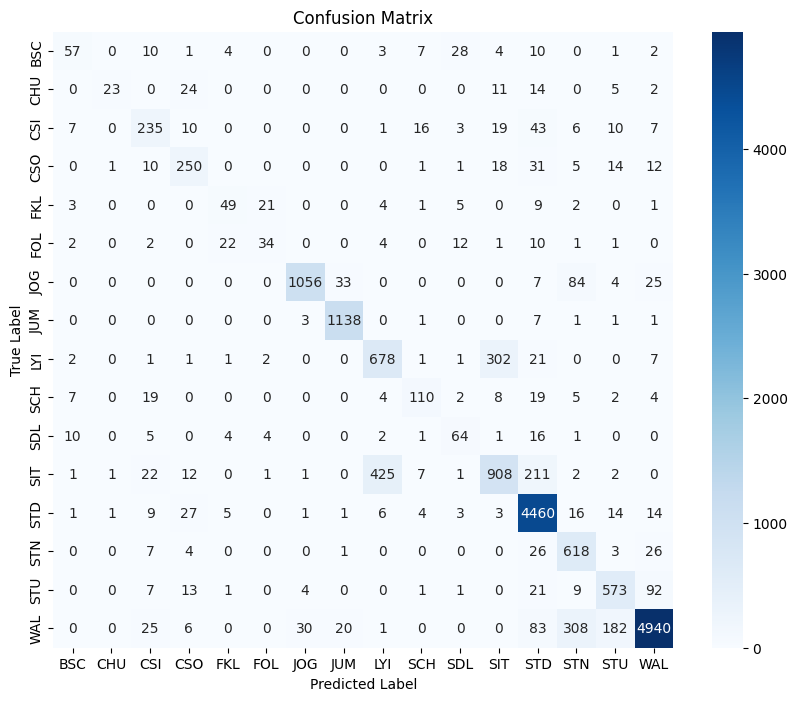

Classification Report:
               precision    recall  f1-score   support

         BSC       0.63      0.45      0.53       127
         CHU       0.88      0.29      0.44        79
         CSI       0.67      0.66      0.66       357
         CSO       0.72      0.73      0.72       343
         FKL       0.57      0.52      0.54        95
         FOL       0.55      0.38      0.45        89
         JOG       0.96      0.87      0.92      1209
         JUM       0.95      0.99      0.97      1152
         LYI       0.60      0.67      0.63      1017
         SCH       0.73      0.61      0.67       180
         SDL       0.53      0.59      0.56       108
         SIT       0.71      0.57      0.63      1594
         STD       0.89      0.98      0.93      4565
         STN       0.58      0.90      0.71       685
         STU       0.71      0.79      0.75       722
         WAL       0.96      0.88      0.92      5595

    accuracy                           0.85     17917
  

In [10]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model_cnn_lstm, X_test_windows, y_test_windows_encoded, label_classes=label_classes)
